# Scraping Rotten Tomatoes and analyse the dataset

This code will **scrape** the website **Rotten Tomatoes** to get the information of the movies available on the website. The information will be stored in a csv file.
Then, the csv file will be used to **analyse the dataset** to find some interesting information.

## Getting the data


### Loading the films on the website Rotten Tomatoes

In order to get the data, we will use the library **Selenium**. Selenium is a library that allows us to automate the browser. We will use it to click on the button "Load more" to get all the movies available on the website.

In [12]:
from selenium.common import NoSuchElementException
from selenium import webdriver
import time
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
# The browser will be Chrome
driver = webdriver.Chrome()
# Open the website Rotten Tomatoes
driver.get("https://www.rottentomatoes.com/browse/movies_at_home/")
try:
    # Click on the button "Reject all" to refuse the cookies, if the button exists. Its a button that appears when you first visit the website.
    # click the button with the id onetrust-reject-all-handler

    reject_all_button = driver.find_element(By.XPATH, "//button[@id='onetrust-reject-all-handler']")
    reject_all_button.click()

except NoSuchElementException:
    print('The button does not exist')
    pass
# The number of times we will click on the button "Load more", each time we click on the button, 30 movies will be added to the list of movies.
number_of_reloading = 50
# Click on the button "Load more" the number of times defined by the variable number_of_reloading
for i in range(number_of_reloading):
    try:
        print('Step', i)
        # Find the button "Load more"
        load_more_button = driver.find_element(By.XPATH, "//button[@data-discoverygridsmanager='btnLoadMore']")
        # Click on the button "Load more"
        load_more_button.click()
    except NoSuchElementException:
        print('The button does not exist')
        pass
    # Pause of 0.5 second between each click on the button "Load more" to let the website load the new movies
    time.sleep(1) # Pause de 1 seconde
# Get the html code of the page in the variable html
html = driver.page_source
# Close the browser
driver.quit()

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49


### Getting the information of each film on the website Rotten Tomatoes

We will use the library **BeautifulSoup** to get the information of each film. We will get the following information:

- The title
- The tomato
- The audience
- The rating
- The genre
- The original language
- The director
- The producer
- The writer
- The release date (theaters)
- The release date (streaming)
- The box office (gross USA)
- The runtime
- The distributor
- The sound mix

In [13]:
# Function to get the information of each film
# Input: the html code of the page
# Output: a dictionary with the information of the film
def get_info(soup):
    # Find the list of information
    list = soup.find("ul", {"id" : "info"})
    # Create a dictionary to store the information
    film_details = {}
    # Get the title of the film
    title = soup.find("h1", {"data-qa" : "score-panel-movie-title"}).text

    film_details["title"] = title


    # Get the information of each category

    for child in list.children:
        # If the category is not empty
        if child.find("b") != -1 :
            # Get the category name
            category = child.find("b").text
            # Remove the ":" at the end of the category
            category = category.replace(':','')
            # Get the value of the category
            value = child.find("span").text
            # Remove the "\n" and the " " in the value
            value = value.strip().replace('\n', '').replace(" ",'').replace(",", ' ')
            # Store the category and the value in the dictionary
            film_details[category] = value
    return film_details

In [14]:
# Create a BeautifulSoup object from the html code of the page. This object will allow us to get the information of each film.
soup = BeautifulSoup(html)

In [15]:
# Find all the divs that contain the information of each film. Each div contains the information of one film.
film_divs= soup.findAll(class_='js-tile-link')

In [16]:
# Create a list to store the link of each film details.
films_link = []
for film in film_divs:
    film_link = {}
    # Get the link of the film details
    link_div = (film.find('a', {"data-track" : "scores"}))
    if link_div is not None:
        # Get the tomato and the audience score
        audiencescore = link_div.find("score-pairs")["audiencescore"]
        tomatoescore = link_div.find("score-pairs")["criticsscore"]
        # Store the link of the film details and the tomato and the audience score in the dictionary.
        film_link["link"] = link_div['href']
        film_link["audiencescore"] = audiencescore
        film_link["tomatoescore"]  = tomatoescore
        films_link.append(film_link)

In [18]:
# Base url of the website
base_url = 'https://www.rottentomatoes.com'
film_details_list = []
number_film = 0
for film_name in films_link:
    print(number_film, "/", len(films_link))
    # Get the url of the film details
    url = base_url + film_name["link"]
    print(url)
    # Get the html code of the page
    response = requests.get(url)
    if response.ok:
        # Create a BeautifulSoup object from the html code of the page. This object will allow us to get the information of each film.
        soup = BeautifulSoup(response.content)
        # Get the information of the film. The function get_info is defined above. It returns a dictionary with the information of the film.
        infos = get_info(soup)
        # Add the tomato and the audience score to the dictionary.
        infos["audiencescore"] = film_name["audiencescore"]
        infos["tomatoescore"] = film_name["tomatoescore"]
        # Add the dictionary to the list.
        film_details_list.append(infos)
    else:
        print("Error")
    time.sleep(0.2) # Pause de 1 seconde
    number_film += 1


0 / 688
https://www.rottentomatoes.com/m/avatar_the_way_of_water
1 / 688
https://www.rottentomatoes.com/m/filmmakers_for_the_prosecution
2 / 688
https://www.rottentomatoes.com/m/im_an_electric_lampshade
3 / 688
https://www.rottentomatoes.com/m/tetris
4 / 688
https://www.rottentomatoes.com/m/murder_mystery_2
5 / 688
https://www.rottentomatoes.com/m/rye_lane
6 / 688
https://www.rottentomatoes.com/m/smoking_causes_coughing
7 / 688
https://www.rottentomatoes.com/m/acidman
8 / 688
https://www.rottentomatoes.com/m/kill_boksoon
9 / 688
https://www.rottentomatoes.com/m/space_oddity
10 / 688
https://www.rottentomatoes.com/m/the_unheard
11 / 688
https://www.rottentomatoes.com/m/prom_pact
12 / 688
https://www.rottentomatoes.com/m/in_viaggio_the_travels_of_pope_francis
13 / 688
https://www.rottentomatoes.com/m/assassin_2023
14 / 688
https://www.rottentomatoes.com/m/capsules_2022
15 / 688
https://www.rottentomatoes.com/m/between_sins
16 / 688
https://www.rottentomatoes.com/m/everything_everywhere_a

In [19]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame(data=film_details_list)
# Drop the columns "View the collection" and "Aspect Ratio"
df = df.drop(["View the collection", "Aspect Ratio"], axis=1)

In [20]:
# Reorder the columns of the dataframe.
df = df[['title', 'tomatoescore','audiencescore','Rating', 'Genre', 'Original Language', 'Director', 'Producer',
       'Writer', 'Release Date (Theaters)', 'Release Date (Streaming)',
       'Box Office (Gross USA)', 'Runtime', 'Distributor', 'Sound Mix']]

In [21]:
# Remove the NaN values, by replacing them with an empty string.
df = df.fillna('')

In [22]:
# Transform the string of the columns Genre, Director, Producer and Writer into a list of strings. For example, the string "Action, Adventure, Comedy" will be transformed into the list ["Action", "Adventure", "Comedy"]
df['Genre'] = df['Genre'].apply(lambda x: x.split())
df['Director'] = df['Director'].apply(lambda x: x.split())
df['Producer'] = df['Producer'].apply(lambda x: x.split())
df['Writer'] = df['Writer'].apply(lambda x: x.split())


In [23]:
df.head(10)

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
0,Avatar: The Way of Water,76,92,PG-13(PartialNudity|IntenseAction|SequencesofS...,"[Sci-fi, Adventure, Action, Fantasy]",English,[JamesCameron],"[JamesCameron, JonLandau]","[JamesCameron, RickJaffa, AmandaSilver]",Dec16 2022 wide,Mar28 2023,$678.3M,3h12m,20thCenturyStudios,DolbyAtmos
1,Filmmakers for the Prosecution,100,,,[Documentary],English,[Jean-ChristopheKlotz],"[CélineNusse, PaulRozenberg, SandraSchulberg]",[Jean-ChristopheKlotz],Jan27 2023 limited,Mar28 2023,,52m,KinoLorber,
2,I'm an Electric Lampshade,71,,,"[Documentary, Music]",English,[JohnClaytonDoyle],"[DougMcCorkle, JacobKrupnick]",[JohnClaytonDoyle],,Mar28 2023,,,GravitasVentures,
3,Tetris,80,92,R(Language),"[Mystery&thriller, Biography, Drama]",English,[JonS.Baird],"[GillianBerrie, LenBlavatnik, GregorCameron, C...",[NoahPink],Mar24 2023 limited,Mar31 2023,,1h58m,AppleTV+,DolbyDigital
4,Murder Mystery 2,,,PG-13(SuggestiveMaterial|BloodyImages|StrongLa...,"[Comedy, Mystery&thriller, Action, Crime]",English,[JeremyGarelick],"[JenniferAniston, AllenCovert, AdamSandler, Ja...",[JamesVanderbilt],Mar24 2023 limited,Mar31 2023,,1h30m,Netflix,DolbyDigital
5,Rye Lane,98,,R(Language|SomeSexualContent|Nudity),"[Romance, Comedy, Drama]",English,[],"[NathanBryon, RoseGarnett, PaulGrindey, Yvonne...","[TomMelia, NathanBryon, TomMelia]",,Mar31 2023,,1h22m,Hulu,
6,Smoking Causes Coughing,100,,,[Comedy],French(France),[QuentinDupieux],[HugoSelignac],[QuentinDupieux],Mar31 2023 limited,Mar31 2023,,1h20m,MagnoliaPictures,
7,Acidman,80,,,"[Drama, Sci-fi]",English,[AlexLehmann],"[LizCardenas, AlexLehmann, DiannaAgron, Christ...","[ChrisDowling, AlexLehmann, ChrisDowling]",Mar31 2023 limited,Mar31 2023,,1h27m,BrainstormMedia,
8,Kill Boksoon,,,TVMA(Language|Smoking|Violence),"[Action, Adventure]",Korean,[ByeonSeonghyeon],[],[ByeonSeonghyeon],,Mar31 2023,,2h17m,Netflix,
9,Space Oddity,44,,PG-13(SomeStrongLanguage|ThematicElements|Sugg...,"[Romance, Comedy, Sci-fi, Drama]",English,[KyraSedgwick],"[ValerieStadler, KyraSedgwick, MeredithBagby, ...",[RebeccaBanner],Mar31 2023 limited,Mar31 2023,,1h32m,SamuelGoldwynFilms,


In [24]:
# Save the dataframe in a csv file
df.to_csv("FilmCSV.csv")

## Data cleaning

Once we have the data, we need to clean it.

In [25]:
import pandas as pd
# Read the csv file that contains the data. The file is in the same folder as the notebook.
df = pd.read_csv("FilmCSV.csv")

In [26]:
# Remove the column Unnamed: 0. It is not useful.
df.drop("Unnamed: 0", axis=1, inplace=True)

In [27]:
df

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
0,Avatar: The Way of Water,76.0,92.0,PG-13(PartialNudity|IntenseAction|SequencesofS...,"['Sci-fi', 'Adventure', 'Action', 'Fantasy']",English,['JamesCameron'],"['JamesCameron', 'JonLandau']","['JamesCameron', 'RickJaffa', 'AmandaSilver']",Dec16 2022 wide,Mar28 2023,$678.3M,3h12m,20thCenturyStudios,DolbyAtmos
1,Filmmakers for the Prosecution,100.0,NaN,NaN,['Documentary'],English,['Jean-ChristopheKlotz'],"['CélineNusse', 'PaulRozenberg', 'SandraSchulb...",['Jean-ChristopheKlotz'],Jan27 2023 limited,Mar28 2023,NaN,52m,KinoLorber,NaN
2,I'm an Electric Lampshade,71.0,NaN,NaN,"['Documentary', 'Music']",English,['JohnClaytonDoyle'],"['DougMcCorkle', 'JacobKrupnick']",['JohnClaytonDoyle'],NaN,Mar28 2023,NaN,NaN,GravitasVentures,NaN
3,Tetris,80.0,92.0,R(Language),"['Mystery&thriller', 'Biography', 'Drama']",English,['JonS.Baird'],"['GillianBerrie', 'LenBlavatnik', 'GregorCamer...",['NoahPink'],Mar24 2023 limited,Mar31 2023,NaN,1h58m,AppleTV+,DolbyDigital
4,Murder Mystery 2,NaN,NaN,PG-13(SuggestiveMaterial|BloodyImages|StrongLa...,"['Comedy', 'Mystery&thriller', 'Action', 'Crime']",English,['JeremyGarelick'],"['JenniferAniston', 'AllenCovert', 'AdamSandle...",['JamesVanderbilt'],Mar24 2023 limited,Mar31 2023,NaN,1h30m,Netflix,DolbyDigital
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,Warcraft,29.0,76.0,PG-13(IntenseFantasyViolence),"['Fantasy', 'Adventure', 'Action']",English,['DuncanJones'],"['CharlesRoven', 'ThomasTull', 'JonJashni', 'A...","['CharlesLeavitt', 'DuncanJones']",Jun10 2016 wide,Sep27 2016,$47.2M,2h3m,UniversalPictures,DolbyAtmos
684,Hatching,92.0,61.0,NaN,['Horror'],Finnish,['HannaBergholm'],"['MikaRitalahti', 'NicoRitalahti', 'NimaYousefi']",['IljaRautsi'],Apr29 2022 limited,May17 2022,$182.8K,1h27m,IFCMidnight,NaN
685,Bohemian Rhapsody,60.0,85.0,PG-13(Language|DrugContent|SuggestiveMaterial|...,"['Biography', 'History', 'Drama', 'Music', 'Lg...",English,['BryanSinger'],"['GrahamKing', 'JimBeach', 'PeterOberth']",['AnthonyMcCarten'],Nov2 2018 wide,Jan22 2019,$216.3M,2h15m,20thCenturyFox,DolbyAtmos
686,Fifty Shades Darker,11.0,48.0,R(SomeGraphicNudity|Language|StrongEroticSexua...,"['Romance', 'Drama']",English,['JamesFoley'],"['MichaelDeLuca', 'E.L.James', 'DanaBrunetti',...",['NiallLeonard'],Feb10 2017 wide,May9 2017,$114.4M,1h58m,UniversalPictures,NaN


In [28]:
# This function converts the string of the column Box Office (Gross USA) into a float. For example, the string "$1.2M" will be converted into the float 1200000.0, and the string "$1.2K" will be converted into the float 1200.0.

def convert_value(value):
    #check if the value is not nan
    if type(value) == float:
        return value
    if value[-1] == 'K':
        return float(value[1:-1]) * 1000
    elif value[-1] == 'M':
        return float(value[1:-1]) * 1000000
    else:
        return float(value[1:])

# apply the function to the column Box Office (Gross USA)
df['Box Office (Gross USA)'] = df['Box Office (Gross USA)'].apply(convert_value)

$678.3M
$75.7M
$58.6M
$17.2M
$43.0M
$596.5K
$171.0M
$10.6M
$92.0M
$64.1M
$35.4M
$140.4M
$123.2M
$182.6M
$32.4M
$6.4M
$4.6M
$15.2M
$95.0M
$38.5M
$5.1M
$6.8M
$168.1M
$11.6M
$718.5M
$17.3M
$3.0M
$103.1M
$453.8M
$32.1M
$151.0M
$45.3M
$105.9M
$8.2M
$369.3M
$90.0M
$40.8M
$2.2M
$8.3M
$188.0M
$176.0M
$500.1K
$109.7M
$39.3M
$5.7M
$55.8M
$343.2M
$6.0M
$26.0M
$14.9M
$335.4M
$858.4M
$1.2M
$10.3M
$34.2M
$44.1M
$376.0M
$20.0M
$754.7K
$2.0M
$21.1K
$37.7M
$27.2M
$38.4M
$53.4M
$23.2M
$36.5M
$45.1M
$31.8M
$166.1M
$164.9M
$6.4M
$515.2M
$108.3M
$620.2M
$2.1M
$411.3M
$3.2M
$5.8M
$147.7M
$1.1M
$211.0K
$525.4K
$224.5M
$58.1M
$38.0M
$3.3M
$175.0M
$23.5M
$37.0M
$142.4M
$27.4M
$330.2M
$2.2M
$12.1M
$7.4M
$48.2M
$91.5M
$678.8M
$190.2M
$134.8M
$93.4M
$4.2M
$165.4M
$50.0M
$10.0M
$700.2M
$151.1M
$68.2M
$50.2M
$658.8M
$15.0M
$46.5M
$21.3K
$281.7M
$46.9M
$36.2M
$330.3M
$27.5M
$426.8M
$180.1K
$12.7M
$12.1M
$291.0M
$318.3M
$220.1M
$32.7M
$190.7M
$9.0M
$10.9M
$11.1M
$292.6M
$100.4M
$10.8M
$68.4M
$22.3M
$149.2M
$30.3M
$69

In [29]:
# Most expensive movies
df_expensive = df.sort_values(by="Box Office (Gross USA)", ascending=False)
#Remove the rows Box Office (Gross USA) with the value nan
df_expensive = df_expensive[df_expensive['Box Office (Gross USA)'].notna()]

In [30]:
df_expensive.head(10)

,title,tomatoescore,audiencescore,Rating,Genre,Original Language,Director,Producer,Writer,Release Date (Theaters),Release Date (Streaming),Box Office (Gross USA),Runtime,Distributor,Sound Mix
91,Avengers: Endgame,94.0,90.0,PG-13(SequencesofSci-FiViolence|Action|SomeLan...,"['Action', 'Adventure', 'Fantasy', 'Sci-fi']",English,"['AnthonyRusso', 'JoeRusso']",['KevinFeige'],"['ChristopherMarkus', 'StephenMcFeely']",Apr26 2019 wide,Jul30 2019,858400000.0,3h1m,WaltDisney,DolbyAtmos DTS SDDS DolbyDigital
46,Top Gun: Maverick,96.0,99.0,PG-13(SomeStrongLanguage|SequencesofIntenseAct...,"['Action', 'Adventure']",English,['JosephKosinski'],"['JerryBruckheimer', 'TomCruise', 'DavidElliso...","['EhrenKruger', 'EricWarrenSinger', 'Christoph...",May27 2022 wide,Aug22 2022,718500000.0,2h11m,ParamountPictures,DolbyAtmos
393,"Confess, Fletch",86.0,75.0,R(SomeSexualContent|Language|DrugUse),"['Comedy', 'Mystery&thriller']",English,['GregMottola'],"['BillBlock', 'JonHamm', 'ConnieTavel']","['GregMottola', 'ZevBorow']",Sep16 2022 wide,Sep16 2022,711600000.0,1h38m,MiramaxFilms,NaN
178,Black Panther,96.0,79.0,PG-13(SequencesofActionViolence|ABriefRudeGest...,"['Action', 'Adventure', 'Fantasy']",English,['RyanCoogler'],['KevinFeige'],"['RyanCoogler', 'JoeRobertCole']",Feb16 2018 wide,May2 2018,700200000.0,2h14m,WaltDisney,DTS DolbyAtmos
163,Avengers: Infinity War,85.0,92.0,PG-13(IntenseSci-FiViolence|ActionThroughout|L...,"['Action', 'Adventure', 'Fantasy', 'Sci-fi']",English,"['AnthonyRusso', 'JoeRusso']",['KevinFeige'],"['ChristopherMarkus', 'StephenMcFeely']",Apr27 2018 wide,Aug14 2018,678800000.0,2h29m,WaltDisney,DolbyAtmos DolbyDigital DTS
0,Avatar: The Way of Water,76.0,92.0,PG-13(PartialNudity|IntenseAction|SequencesofS...,"['Sci-fi', 'Adventure', 'Action', 'Fantasy']",English,['JamesCameron'],"['JamesCameron', 'JonLandau']","['JamesCameron', 'RickJaffa', 'AmandaSilver']",Dec16 2022 wide,Mar28 2023,678300000.0,3h12m,20thCenturyStudios,DolbyAtmos
185,Titanic,88.0,69.0,PG-13(DisasterRelatedPeril|BriefLanguage|Nudit...,"['History', 'Drama', 'Romance']",English,['JamesCameron'],"['JamesCameron', 'JonLandau']",['JamesCameron'],Dec19 1997 wide,Jan8 2002,658800000.0,3h15m,20thCenturyFox ParamountPictures,DolbyDigital DolbySR DolbyStereo Surround DTS ...
677,Jurassic World,71.0,78.0,PG-13(Peril|IntenseSci-FiViolence),"['Adventure', 'Action', 'Sci-fi', 'Mystery&thr...",English,['ColinTrevorrow'],"['FrankMarshall', 'PatrickCrowley']","['RickJaffa', 'AmandaSilver', 'DerekConnolly',...",Jun12 2015 wide,Oct20 2015,652600000.0,2h4m,UniversalPictures,Datasat DolbyDigital
127,Star Wars: The Last Jedi,91.0,42.0,PG-13(Violence|SequencesofSci-FiAction),"['Sci-fi', 'Adventure', 'Action', 'Fantasy']",English,['RianJohnson'],"['KathleenKennedy', 'RamBergman']",['RianJohnson'],Dec15 2017 wide,Mar27 2018,620200000.0,2h32m,WaltDisney,DolbyDigital DolbyAtmos DTS
276,The Lion King,52.0,88.0,PG(SequencesofViolence|Peril|SomeThematicEleme...,"['Kids&family', 'Adventure', 'Drama']",English,['JonFavreau'],"['JonFavreau', 'JeffreySilver', 'KarenGilchrist']",['JeffNathanson'],Jul19 2019 wide,Aug27 2019,543600000.0,1h58m,WaltDisney,DTS DolbyDigital DolbyAtmos


In [34]:
# Find correlation between the box office, the audience score and the tomato score
df_expensive[['Box Office (Gross USA)', 'audiencescore', 'tomatoescore']].corr()

,Box Office (Gross USA),audiencescore,tomatoescore
Box Office (Gross USA),1.000000,0.143631,0.049720
audiencescore,0.143631,1.000000,0.509453
tomatoescore,0.049720,0.509453,1.000000


<Axes: xlabel='Box Office (Gross USA)', ylabel='audiencescore'>

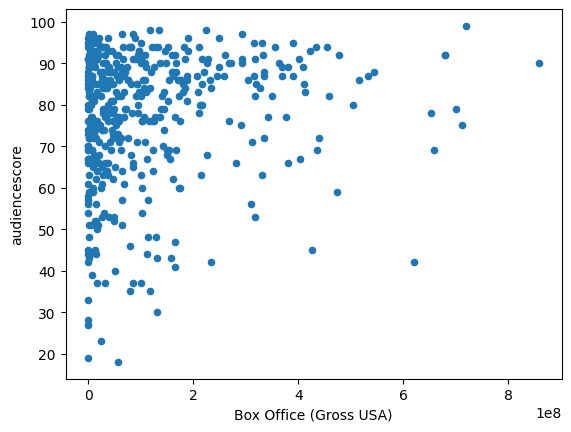

In [35]:
# draw a scatter plot between the box office and the audience score
import matplotlib
df_expensive.plot.scatter(x='Box Office (Gross USA)', y='audiencescore')

In [60]:
list_of_genres = []
# Get all the genres as a list of strings
genres_list = df['Genre'].apply(lambda x: x.split(','))
# replace the "[" and the "]" and ' by an empty string
genres_list = genres_list.apply(lambda x: [genre.replace('[', '').replace(']', '').replace("'", '').replace(' ', '') for genre in x])
for genres in genres_list:
    for genre in genres:
        if genre not in list_of_genres:
            list_of_genres.append(genre)
print(list_of_genres)

['Sci-fi', 'Adventure', 'Action', 'Fantasy', 'Documentary', 'Music', 'Mystery&thriller', 'Biography', 'Drama', 'Comedy', 'Crime', 'Romance', 'Horror', 'Kids&family', 'Animation', 'War', 'History', 'Musical', 'Lgbtq+', 'Sports', 'Western', 'Holiday', 'Stand-up', 'Anime']


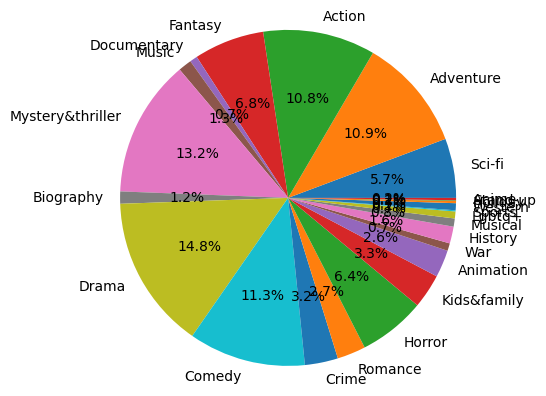

In [104]:
import matplotlib.pyplot as plt

df_filtered = {}
for genre in list_of_genres:
    df_filtered[genre] = len(df[df['Genre'].str.contains(genre)])
# Repartition of the genres in the dataframe, with the number of movies for each genre.
# plot the repartition of the genres, with the number of movies for each genre.
# Création du graphique camembert
fig, ax = plt.subplots()
keys_list = list(map(str, df_filtered.keys()))
values = list(df_filtered.values())
ax.pie(values,labels=keys_list, autopct='%1.1f%%')
plt.axis('equal')

# Affichage du graphique
plt.show()